In [1]:
#@title Runtime
use_tpu = False #@param

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
import tensorflowjs as tfjs
# import tensorflow_decision_forests as tfdf
import json
from tqdm import tqdm
import seaborn as sns
np.random.seed(0)

In [3]:
# urllib.request.urlretrieve(
#     "https://github.com/ur-whitelab/peptide-ai/tree/master/scripts/active_learning_data/anticancer-sequence-vectors.npy",
#     "positive.npy",
# )
# urllib.request.urlretrieve(
#     "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-negative.npz",
#     "negative.npz",
# )
# with np.load("positive.npz") as r:
#     pos_data = r[list(r.keys())[0]]
pos_ohe_data = np.load("anticancer-sequence-vectors.npy",  allow_pickle=True)
neg_ohe_data = np.load("anticancer-fake-sequence-vectors.npy",  allow_pickle=True)
ALPHABET = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
def ohe_to_seq(ohe_pep):
    seq = ''
    # expect a 2D numpy array (pep_length x 20), give the string it represents
    for letter in ohe_pep[:int(np.sum(ohe_pep))]:
        idx = np.argmax(letter)
        if letter[idx] == 0:
            break
        seq += ALPHABET[idx]
    return(seq)

def encoder(seq, max_length=190):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    vec = np.zeros(max_length)
    for i,l in enumerate(seq):
        vec[i] = alphabet.index(l) + 1
    return vec
pos_seqs = [ohe_to_seq(d) for d in pos_ohe_data]
pos_data = np.array([encoder(s) for s in pos_seqs])
neg_seqs = [ohe_to_seq(d) for d in neg_ohe_data]
neg_data = np.array([encoder(s) for s in neg_seqs])
# with np.load("negative.npz") as r:
#     neg_data = r[list(r.keys())[0]]

# create labels and stich it all into one
# tensor
# labels = np.concatenate(
#     (
#         np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
#         np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
#     ),
#     axis=0,
# )
# weights = np.concatenate(
#     (np.ones((pos_data.shape[0]), dtype=pos_data.dtype), 
#      weights)
# )
# features = np.concatenate((pos_data, neg_data), axis=0)
# pos_data_lengths = np.count_nonzero(pos_data, axis=1)
# neg_data_lengths = np.count_nonzero(neg_data, axis=1)

In [4]:
max_length = pos_data.shape[1]
def encoder(seq, max_length=200):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    vec = np.zeros(max_length)
    for i,l in enumerate(seq):
        vec[i] = alphabet.index(l) + 1
    return vec
# sample unlabeled data
def sample_permutations_from_vec(data_lengths, labeled_unlabeled_ratio=0.2, max_sequence_length=200):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    with open("../pdb_dist.txt", 'r') as f:
        # the probabilities in this file are sorted based on the alphabet list above
        pdb_dist = f.read().split()
        pdb_dist = [float(item) for item in pdb_dist]
#     unlabeled_seq_lengths = vec_pep_length(positive_data, ohe_vec=False)
#     print(unlabeled_seq_lengths)
    sampled_lengths = []
    for length in data_lengths:
        length_sample_batch = np.ones(int(1/labeled_unlabeled_ratio), dtype=int) * length
        sampled_lengths.append(length_sample_batch)
    sampled_lengths = np.array(sampled_lengths).flatten()
    sampled_sequences = []
    sampled_vecs = []
    for length in tqdm(sampled_lengths):
#         print(length)
    #         random_alphabet_index = np.random.randint(len(alphabet), size=length)
        # sample alphabet index based on weighted amino acid frequencies in pdb
        random_alphabet_index = np.random.choice(len(alphabet), size=length, p=pdb_dist)
        for _ in range(length):
            pep = ''.join([alphabet[m] for m in random_alphabet_index])
        vec_pep = encoder(pep, max_length=max_length)
        # pad zeros
    #     print(ohe_pep.shape)
#         ohe_pep = np.concatenate([ohe_pep, np.zeros((max_sequence_length-ohe_pep.shape[0],20))],axis=0)
        sampled_vecs.append(vec_pep)
        sampled_sequences.append(pep)
#     sampled_vecs = np.array(sampled_vecs)
    return sampled_sequences, sampled_vecs
# ohe_sequence_list = np.concatenate([ohe_sequence_list, np.zeros((190,10))],axis=1)
pos_data_lengths = np.count_nonzero(pos_data, axis=1) + 1
neg_data_lengths = np.count_nonzero(neg_data, axis=1) + 1
labeled_unlabeled_ratio = 0.2
sampled_sequences, sampled_vecs = sample_permutations_from_vec(pos_data_lengths,
                                                               labeled_unlabeled_ratio=0.2, max_sequence_length=max_length)
sampled_vecs = np.array(sampled_vecs)
# X_unlabeled = sampled_vecs
unlabeled_data_lengths = []
for seq in sampled_sequences:
    unlabeled_data_lengths.append(len(seq))

100%|██████████| 1145/1145 [00:00<00:00, 6785.97it/s]


In [5]:
X_positive = pos_data
X_negative = neg_data
X_unlabeled = sampled_vecs
print('Positive data:', pos_data.shape[0])
print('Negative data:', neg_data.shape[0])
print('Sampled unlabeled data:', len(sampled_sequences))

Positive data: 229
Negative data: 229
Sampled unlabeled data: 1145


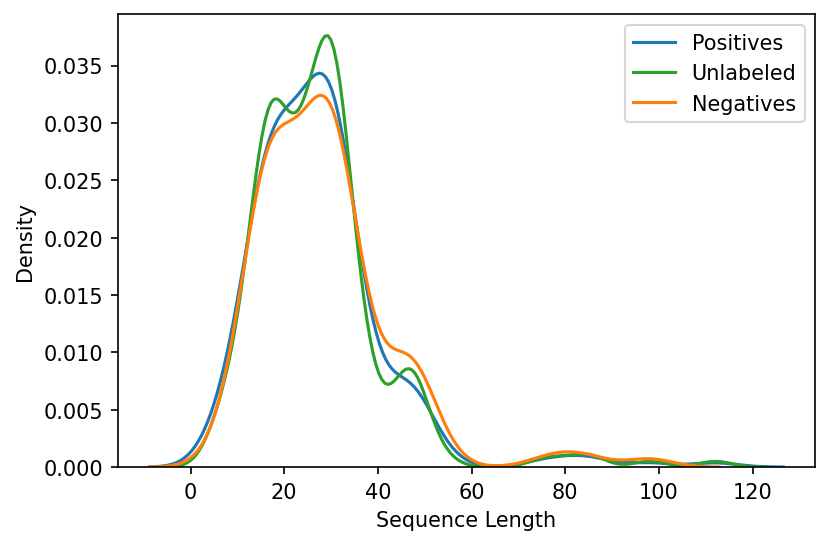

In [6]:
fig, ax = plt.subplots(dpi=150)
sns.kdeplot(pos_data_lengths, ax=ax, label='Positives', color='C0')
ax.set_xlabel('Sequence Length')
# ax.set_title(f'{peptide_label}')
sns.kdeplot(unlabeled_data_lengths, ax=ax, label='Unlabeled', color='C2')
sns.kdeplot(neg_data_lengths, ax=ax, label='Negatives', color='C1')
plt.legend()

In [7]:
# Generating UniRep representations for postives, negatives and unlableled (This cell takes long to run)
from jax_unirep import get_reps
h_avg, h_final, c_final = get_reps(pos_seqs)
pos_UniRep = h_avg

h_avg, h_final, c_final = get_reps(neg_seqs)
neg_UniRep = h_avg

h_avg, h_final, c_final = get_reps(sampled_sequences)
unlabeled_UniRep = h_avg

/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)
/home/mgholiza/.conda/envs/covid-19/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [8]:
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.model_selection import KFold
# from sklearn.metrics import f1_score
# from sklearn.metrics import recall_score
# kf = KFold(n_splits=5, random_state=None, shuffle=True)
# f1_scores = []
# recall_scores = []
# i = 0

# for train_index, test_index in kf.split(pos_UniRep):
#     X_train_positive_lof, X_test_positive_lof = pos_UniRep[train_index], pos_UniRep[test_index]
# #     s_train_positive_svm = np.ones(X_train_positive_svm.shape[0])
# #     s_test_positive_svm = y[train_index], y[test_index]
#     s_test_lof = np.ones(X_test_positive_lof.shape[0])
#     lof = LocalOutlierFactor(n_neighbors=64, algorithm='auto',
#                              metric='cosine', contamination=0.01,
#                              novelty=True, n_jobs=20, leaf_size=40)
#     lof.fit(X_train_positive_lof)
# #     X_validation_svm = np.concatenate([X_positive_test, X_unlabeled_test])

#     # Make prediction
#     s_pred = lof.predict(X_test_positive_lof)
#     f1 = f1_score(s_test_lof, s_pred, average='macro')
#     r = recall_score(s_test_lof, s_pred, average='macro')
#     print(f'Fold {i+1} - recall : {r:.3f}, f1 score : {f1:.3f}')
#     f1_scores.append(f1)
#     recall_scores.append(r)
#     i += 1
# #     break
# # lof_f1_score
# lof_f1_score = np.mean(f1_scores)
# lof_recall_score = np.mean(recall_scores)
# print(f'\nMean 5-Fold\n f1 score = {lof_f1_score:.3f}\n recall = {lof_recall_score:.3f}')

In [9]:
def mahalanobis_distance(x, data):
    data = np.unique(data, axis=0)
    x_minus_mu = x - np.mean(data, axis=0, keepdims=True)
    cov = np.cov(data.T)
    inv_covmat = np.linalg.pinv(cov)
    left_term = x_minus_mu @ inv_covmat
    mahal = left_term @ x_minus_mu.T
    return mahal.diagonal()
unlabeled_mahal_d = mahalanobis_distance(unlabeled_UniRep, pos_UniRep)
sorted_max_mahal_d_index = np.argsort(unlabeled_mahal_d)[::-1]
outlier_index = sorted_max_mahal_d_index[sorted_max_mahal_d_index[:50]]
initial_RNs = X_unlabeled[outlier_index]

In [10]:
# Shuffling data
shuffled_indices = np.random.permutation(len(pos_data))
X_positive = pos_data[shuffled_indices]
shuffled_indices = np.random.permutation(len(neg_data))
X_negative = neg_data[shuffled_indices]
# shuffled_indices = np.random.permutation(len(sampled_vecs))
# X_unlabeled = sampled_vecs[shuffled_indices]

In [11]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(X_positive), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts/tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='hemo-rnn')
    return model

In [12]:
from sklearn.model_selection import train_test_split
X_train_positive, X_test_positive, y_train_positive, y_test_positive = train_test_split(X_positive, np.ones(X_positive.shape[0]),
                                                                                        test_size=0.2, random_state=42)

In [13]:
RNs = initial_RNs
down_sampled_X_train = X_train_positive[np.random.choice(X_train_positive.shape[0], size=RNs.shape[0], replace=False)]
X_train_with_RN = np.concatenate([X_train_positive, RNs])
counts_X_train_with_RN= np.array([counts_aa(xi) for xi in X_train_with_RN])
y_train_with_RN = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(RNs.shape[0])])
shuffler = np.random.permutation(len(X_train_with_RN))
X_train_with_RN = X_train_with_RN[shuffler]
# counts_X_train_with_RN = counts_X_train_with_RN[shuffler]
y_train_with_RN = y_train_with_RN[shuffler]
# down_sampled_X_negative = X_negative[np.random.choice(X_negative.shape[0], size=RNs.shape[0], replace=False)]
X_test = np.concatenate([X_test_positive, X_negative])
y_test = np.concatenate([np.ones(y_test_positive.shape[0]), np.zeros(X_negative.shape[0])])
# removing intial RN seeds from unlabeled
# RU = np.delete(X_unlabeled, outlier_index[0],axis=0)
RU = X_unlabeled
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9,
                                                        patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, min_delta=1e-2, restore_best_weights=True)
L = None
decay_epochs = 50
N = len(X_train_with_RN)
decay_steps = N  // config.batch_size * decay_epochs
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
  config.lr, decay_steps, alpha=1e-3)
for i in tqdm(range(50)):
    tf.keras.backend.clear_session()
    model = build_model(L)
    model.compile(
            optimizer=tf.optimizers.Adam(lr_decayed_fn),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)],
            )
    history = model.fit(
        [X_train_with_RN, counts_X_train_with_RN] , y_train_with_RN,
        validation_data=([X_test, np.array([counts_aa(xi) for xi in X_test])] , y_test), 
        epochs=50,
        batch_size=16,
    #     batch_size=64,
    #     steps_per_epoch=100,
        # early_stopping
        callbacks=[reduce_lr, early_stopping],
        verbose=1,
    #         class_weight=class_weights
    )
    prob = model.predict([RU, np.array([counts_aa(xi) for xi in RU])])
    V = RU[np.argsort(prob[:,0])] 
#     break
#     print(f'Negatives found: {V.shape[0]}')
#     if V.shape[0] == 0:
#         print('All unlabeled were predicted as positive')
#         RNs = outlier_values
#         break
    # print(V.shape)
#     else:
        # print(RNs.shape)
#         n_downsample = V.shape[0] - X_train_positive_svm.shape[0]
#         print(RNs.shape) 
    if i == 0:
        RNs = np.empty(shape=(0, 200))

#     RNs = np.concatenate([RNs, V[:20*(i+1)]])
    RNs = V[:80*(i+1)]
#         RU = RU[:][np.squeeze(prob > 0.001)]
#     RU = np.delete(RU, np.argsort(prob[:,0])[:20*(i+1)], axis=0)
    print(f'Reliable negative size: {RNs.shape[0]}   Unlabeled size: {RU.shape[0]}')
    if RU.shape[0] == 0:
        print('All unlabeled were predicted as negative')
        break
    if RNs.shape[0] > X_train_positive.shape[0]:
        print('RNs size exceeded positives size')
        break
#         RNs = equalizer(X_train_positive_lof, RNs)
    down_sampled_X_train = X_train_positive[np.random.choice(X_train_positive.shape[0], size=RNs.shape[0], replace=False)]
    print(f'pos size: {down_sampled_X_train.shape[0]} RN size: {RNs.shape[0]}')
    X_train_with_RN = np.concatenate([X_train_positive, RNs])
    counts_X_train_with_RN = np.array([counts_aa(xi) for xi in X_train_with_RN])
    y_train_with_RN = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(RNs.shape[0])])
    shuffler = np.random.permutation(len(X_train_with_RN))
    X_train_with_RN = X_train_with_RN[shuffler]
    counts_X_train_with_RN = counts_X_train_with_RN[shuffler]
    y_train_with_RN = y_train_with_RN[shuffler]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
15/15 [==============================] - 12s 202ms/step - loss: 0.6158 - auc: 0.5269 - binary_accuracy: 0.7296 - val_loss: 1.5003 - val_auc: 0.5600 - val_binary_accuracy: 0.1673
Epoch 2/50
15/15 [==============================] - 0s 22ms/step - loss: 0.4122 - auc: 0.8175 - binary_accuracy: 0.8155 - val_loss: 2.4585 - val_auc: 0.7204 - val_binary_accuracy: 0.1709
Epoch 3/50
15/15 [==============================] - 0s 22ms/step - loss: 0.1588 - auc: 0.9781 - binary_accuracy: 0.9442 - val_loss: 2.7015 - val_auc: 0.5968 - val_binary_accuracy: 0.3418
Epoch 4/50
15/15 [==============================] - 0s 25ms/step - loss: 0.1280 - auc: 0.9844 - binary_accuracy: 0.9571 - val_loss: 3.2133 - val_auc: 0.6377 - val_binary_accuracy: 0.2836
Epoch 5/50
15/15 [==============================] - 0s 24ms/step - loss: 0.0994 - auc: 0.9914 - binary_accuracy: 0.9657 - val_loss: 3.2689 - val_auc: 0.6811 - val_binary_accuracy: 0.2764
Epoch 6/50
15/15 [==============================] - 0s 24ms/ste

  2%|▏         | 1/50 [00:19<15:49, 19.37s/it]

Reliable negative size: 80   Unlabeled size: 1145
pos size: 80 RN size: 80
Epoch 1/50
17/17 [==============================] - 12s 251ms/step - loss: 0.3455 - auc: 0.9145 - binary_accuracy: 0.8517 - val_loss: 3.1754 - val_auc: 0.6620 - val_binary_accuracy: 0.1891
Epoch 2/50
17/17 [==============================] - 0s 23ms/step - loss: 0.1160 - auc: 0.9915 - binary_accuracy: 0.9582 - val_loss: 3.5683 - val_auc: 0.5051 - val_binary_accuracy: 0.1855
Epoch 3/50
17/17 [==============================] - 0s 22ms/step - loss: 0.0649 - auc: 0.9988 - binary_accuracy: 0.9848 - val_loss: 2.7171 - val_auc: 0.6782 - val_binary_accuracy: 0.3455
Epoch 4/50
17/17 [==============================] - 0s 23ms/step - loss: 0.0597 - auc: 0.9984 - binary_accuracy: 0.9924 - val_loss: 2.5477 - val_auc: 0.7624 - val_binary_accuracy: 0.3673
Epoch 5/50
17/17 [==============================] - 0s 22ms/step - loss: 0.0446 - auc: 0.9995 - binary_accuracy: 0.9886 - val_loss: 3.4439 - val_auc: 0.6433 - val_binary_accur

  4%|▍         | 2/50 [00:39<15:46, 19.73s/it]

Epoch 1/50
22/22 [==============================] - 13s 142ms/step - loss: 0.1923 - auc: 0.9795 - binary_accuracy: 0.9242 - val_loss: 2.6134 - val_auc: 0.6585 - val_binary_accuracy: 0.2800
Epoch 2/50
22/22 [==============================] - 0s 20ms/step - loss: 0.0428 - auc: 0.9998 - binary_accuracy: 0.9913 - val_loss: 3.1728 - val_auc: 0.5823 - val_binary_accuracy: 0.2255
Epoch 3/50
22/22 [==============================] - 0s 20ms/step - loss: 0.0227 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.2682 - val_auc: 0.6592 - val_binary_accuracy: 0.2655
Epoch 4/50
22/22 [==============================] - 0s 21ms/step - loss: 0.0129 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.4586 - val_auc: 0.5987 - val_binary_accuracy: 0.2764
Epoch 5/50
22/22 [==============================] - 0s 21ms/step - loss: 0.0088 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.0073 - val_auc: 0.6637 - val_binary_accuracy: 0.2145
Epoch 6/50
22/22 [==============================] - 0s 22ms/ste

  4%|▍         | 2/50 [01:00<24:16, 30.35s/it]

Reliable negative size: 240   Unlabeled size: 1145
RNs size exceeded positives size


Now train with found RNs and positives. We do testing and validation based on the known negative data and a small subset of unobserved postives

In [14]:
# from sklearn.model_selection import train_test_split
# X_train_positive, X_test_positive, y_train_positive, y_test_positive = train_test_split(pos_data,
#                                                                                np.ones(pos_data.shape[0]),
#                                                                                test_size=0.1, random_state=25)
# X_val_positive, X_test_positive, y_val_positive, y_test_positive = train_test_split(X_test_positive,
#                                                                                     y_test_positive,
#                                                                                     test_size=0.2, random_state=25)
# X_train = np.concatenate([X_train_positive, RNs])
# y_train = np.concatenate([y_train_positive, np.zeros(RNs.shape[0])])
# neg_val_indices = np.random.choice(X_negative.shape[0], size=X_val_positive.shape[0], replace=False)
# X_negative_dummy = np.delete(X_negative, neg_val_indices, axis=0)
# neg_test_indices = np.random.choice(X_negative_dummy.shape[0], size=X_test_positive.shape[0], replace=False)
# X_val = np.append(X_val_positive, X_negative[neg_val_indices], axis=0)
# y_val = np.append(y_val_positive, np.zeros(y_val_positive.shape[0]), axis=0)
# X_test = np.append(X_test_positive, X_negative[neg_test_indices], axis=0)
# y_test = np.append(y_test_positive, np.zeros(y_test_positive.shape[0]), axis=0)
# shuffler = np.random.permutation(len(X_train))
# X_train = X_train[shuffler]
# y_train = y_train[shuffler]
# shuffler = np.random.permutation(len(X_val))
# X_val = X_val[shuffler]
# y_val = y_val[shuffler]
# shuffler = np.random.permutation(len(X_test))
# X_test = X_test[shuffler]
# y_test = y_test[shuffler]



In [15]:
labels = np.concatenate(
    (
        np.ones(pos_data.shape[0], dtype=pos_data.dtype),
        np.zeros(RNs.shape[0], dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, RNs), axis=0)
counts_features = np.array([counts_aa(xi) for xi in features])
shuffler = np.random.permutation(len(features))
features = features[shuffler]
counts_features = counts_features[shuffler]
labels = labels[shuffler]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=25)
# add true known negatives to validation and test data
split = X_negative.shape[0]//5 *4
X_negative_val, X_negative_test = X_negative[:split], X_negative[split:]
X_val = np.append(X_val, X_negative_val, axis=0)
y_val = np.append(y_val, np.zeros(X_negative_val.shape[0]), axis=0)
X_test = np.append(X_test, X_negative_test, axis=0)
y_test = np.append(y_test, np.zeros(X_negative_test.shape[0]), axis=0)
shuffler = np.random.permutation(len(X_val))
X_val = X_val[shuffler]
y_val = y_val[shuffler]
shuffler = np.random.permutation(len(X_test))
X_test = X_test[shuffler]
y_test = y_test[shuffler]


(array([55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

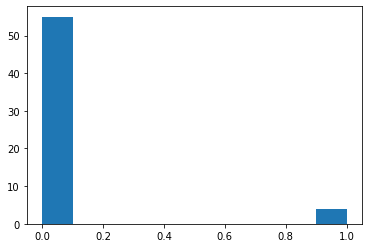

In [16]:
plt.hist(y_test)

In [17]:
tf.keras.backend.clear_session()
model = build_model(L)
#   L = 190
#   model = build_CNN_model(L, reg=0, add_dropout=True)
decay_epochs = 50
N = len(features)
decay_steps = N  // config.batch_size * decay_epochs
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
  config.lr, decay_steps, alpha=1e-3)
opt = tf.optimizers.Adam(lr_decayed_fn)
model.compile(
  opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  steps_per_execution = 60 if use_tpu else None,
  metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [18]:
result = model.fit(
    [X_train, np.array([counts_aa(xi) for xi in X_train])], y_train, 
    validation_data=([X_val, np.array([counts_aa(xi) for xi in X_val])] , y_val),
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=5)],
    epochs=150, batch_size=16)

Epoch 1/150
lr = 0.001
27/27 [==============================] - 12s 116ms/step - loss: 0.2545 - auc: 0.9700 - binary_accuracy: 0.8886 - val_loss: 1.8053 - val_auc: 0.8307 - val_binary_accuracy: 0.3502
Epoch 2/150
lr = 0.0009991456
27/27 [==============================] - 1s 21ms/step - loss: 0.0373 - auc: 0.9975 - binary_accuracy: 0.9976 - val_loss: 2.9133 - val_auc: 0.6525 - val_binary_accuracy: 0.2212
Epoch 3/150
lr = 0.0009965852
27/27 [==============================] - 1s 20ms/step - loss: 0.0167 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.1844 - val_auc: 0.6100 - val_binary_accuracy: 0.2258
Epoch 4/150
lr = 0.0009923278
27/27 [==============================] - 1s 20ms/step - loss: 0.0143 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.4106 - val_auc: 0.6075 - val_binary_accuracy: 0.1935
Epoch 5/150
lr = 0.0009863877
27/27 [==============================] - 1s 20ms/step - loss: 0.0115 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.6054 - val_auc: 0.5976 - val

2/2 [==============================] - 0s 6ms/step - loss: 1.6084 - auc: 0.9159 - binary_accuracy: 0.4068


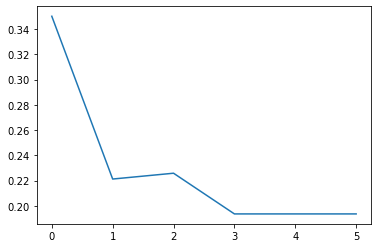

In [19]:
plt.plot(result.history['val_binary_accuracy'])
PU_test_result = model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)
plt.show()

(array([ 9.,  2.,  1.,  1.,  3.,  4.,  4.,  0.,  7., 28.]),
 array([-4.810681  , -4.0143714 , -3.2180624 , -2.421753  , -1.6254437 ,
        -0.82913446, -0.03282518,  0.7634841 ,  1.5597934 ,  2.3561027 ,
         3.152412  ], dtype=float32),
 <BarContainer object of 10 artists>)

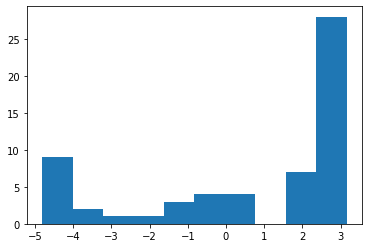

In [20]:
plt.hist(model.predict([X_test, np.array([counts_aa(xi) for xi in X_test])]))

Let's see how the model works with classical positive-negative classification

In [21]:
labels = np.concatenate(
    (
        np.ones(pos_data.shape[0], dtype=pos_data.dtype),
        np.zeros(neg_data.shape[0], dtype=neg_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
counts_features = np.array([counts_aa(xi) for xi in features])
shuffler = np.random.permutation(len(features))
features = features[shuffler]
counts_features = counts_features[shuffler]
labels = labels[shuffler]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=25)

In [22]:
tf.keras.backend.clear_session()
model = build_model(L)
opt = tf.optimizers.Adam(lr_decayed_fn)
model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [23]:
result = model.fit(
    [X_train, np.array([counts_aa(xi) for xi in X_train])], y_train, 
    validation_data=([X_val, np.array([counts_aa(xi) for xi in X_val])] , y_val),
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=5)],
    epochs=150)

Epoch 1/150
lr = 0.001
13/13 [==============================] - 12s 317ms/step - loss: 0.6081 - auc: 0.7333 - binary_accuracy: 0.6650 - val_loss: 0.5041 - val_auc: 0.8438 - val_binary_accuracy: 0.8056
Epoch 2/150
lr = 0.0009998019
13/13 [==============================] - 0s 23ms/step - loss: 0.4022 - auc: 0.9027 - binary_accuracy: 0.8325 - val_loss: 0.3906 - val_auc: 0.8891 - val_binary_accuracy: 0.8889
Epoch 3/150
lr = 0.0009992077
13/13 [==============================] - 0s 22ms/step - loss: 0.3117 - auc: 0.9324 - binary_accuracy: 0.8956 - val_loss: 0.3691 - val_auc: 0.8953 - val_binary_accuracy: 0.8889
Epoch 4/150
lr = 0.000998218
13/13 [==============================] - 0s 22ms/step - loss: 0.3146 - auc: 0.9313 - binary_accuracy: 0.8883 - val_loss: 0.4821 - val_auc: 0.9047 - val_binary_accuracy: 0.7778
Epoch 5/150
lr = 0.0009968332
13/13 [==============================] - 0s 21ms/step - loss: 0.3277 - auc: 0.9244 - binary_accuracy: 0.8835 - val_loss: 0.4243 - val_auc: 0.8906 - val_

1/1 [==============================] - 0s 23ms/step - loss: 0.0402 - auc: 1.0000 - binary_accuracy: 1.0000


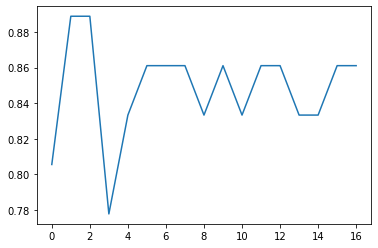

In [24]:
plt.plot(result.history['val_binary_accuracy'])
PN_test_result = model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)
plt.show()

In [25]:
import pandas as pd
od = 'Mahalanobis Distance'
task = 'Anticancer'
DNN_type = 'Bi-LSTM'
if od == 'Mahalanobis Distance':
    mean_od_recall_score = '-'
PN_auc = PN_test_result[1]
PN_acc = PN_test_result[2]
    
df = pd.DataFrame({'Task': [task],
                   'n positives': [X_positive.shape[0]],
                   'n negatives': [X_negative.shape[0]],
                   'n unlabeled': [X_unlabeled.shape[0]],
                   'n RNs': [RNs.shape[0]],
                   'Outlier detector': [od],
                   'Outlier recall score': [mean_od_recall_score],
                   'DNN model': [DNN_type],
                   'PN auc': [PN_test_result[1]],
                   'PN accuracy': [PN_test_result[2]],
                   'PU auc': [PU_test_result[1]],
                   'PU accuracy': [PU_test_result[2]],
                  })

df
# df.to_csv(f'pu_workflow/results/T=0.01/{dat}_{od}_{DNN_type}.csv', index=False, sep='\t')

,Task,n positives,n negatives,n unlabeled,n RNs,Outlier detector,Outlier recall score,DNN model,PN auc,PN accuracy,PU auc,PU accuracy
0,Anticancer,229,229,1145,240,Mahalanobis Distance,-,Bi-LSTM,1.0,1.0,0.915909,0.40678
